<a href="https://colab.research.google.com/github/katearb/ipynb-projects/blob/master/w1_EDA_DP_DR_june2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### EDA, Data Preparation and Dimensional Reduction on [Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/bank+marketing)

In [ ]:
!pip install umap-learn

     |████████████████████████████████| 81kB 4.4MB/s 
     |████████████████████████████████| 1.1MB 10.9MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=abe8938bafc3fcb37c97e7e6772f143002355d015874000e811980214d608d33
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.4-cp37-none-any.whl size=52374 sha256=ce4c35c59b9c0e7e44535224b10750577dd5de37c2c4cbec09f9399b8ae1688f
  Stored in directory: /root/.cache/pip/wheels/42/4b/8c/f6f119c67cf6583bb192431fa8f7278cf95e5b943055077d94
Successfully built umap-learn pynndescent


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, RobustScaler, OrdinalEncoder

import umap.umap_ as umap

In [ ]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'font.size': 13})

In [ ]:
data = pd.read_csv(r'https://raw.githubusercontent.com/katearb/files/main/bank-additional-full.csv', sep=';', na_values='unknown')

In [ ]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Part 1: EDA

#### Step 1: Univariant analysis

In [ ]:
# exploring data types
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [ ]:
# split data into numeric and categorical
numeric_columns = data.select_dtypes('number').columns
numeric_data = data[numeric_columns] 

categorical_columns = data.select_dtypes(np.object).columns
categorical_data = data[categorical_columns]
categorical_data.drop('y', axis=1)

target = data['y']

In [ ]:
numeric_data

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6


In [ ]:
categorical_data

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,NaN,no,no,telephone,may,mon,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,no
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,cellular,nov,fri,nonexistent,yes
41184,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,nonexistent,no
41185,retired,married,university.degree,no,yes,no,cellular,nov,fri,nonexistent,no
41186,technician,married,professional.course,no,no,no,cellular,nov,fri,nonexistent,yes


In [ ]:
# exploring target value
target.describe()

count     41188
unique        2
top          no
freq      36548
Name: y, dtype: object

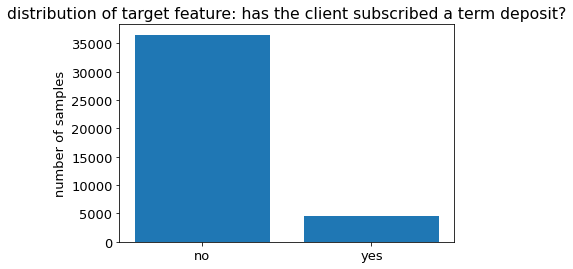

In [ ]:
# visualize target value
bar_info_target = target.value_counts()
plt.bar(x=bar_info_target.index, height=bar_info_target)
plt.title('distribution of target feature: has the client subscribed a term deposit?')
plt.ylabel('number of samples')
plt.show()

One of two possible values is much more frequent. It can affect our model while learning.

In [ ]:
# exploring descriptive statistics for numeric data
numeric_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


1. Age: As the median is a bit less than mean values, this means that the distribution is positive skewed. As the result, outliers are expected among bigger values which the max value also indicates.
2. Duration: Standart deviation is huge: data is very spread out from the mean. Median is much less than mean value --> the distribution is great positive skewed.
3. Campaign: the distribution is also positive skewed, but the range of values is not so big, as in previous features. However, the outliers are observed 
at the upper limit of the values.
4. Pdays: Obviously, there is one dominant value (999), but as the mean is somewhat less, some very little values are also expected to be there.
5. Previous: There is also one the most frequent value (0). Both mean and std are near this value. Max value look like outlier.
6. Emp.var.rate: negative skewed.
7. cons.price.idx: very narrow range. Mean is almost equal to median.
8. cons.conf.idx: interesting that value between 50% snd 75% is changing so drematicaly, compared to 25% --> 50%. It seems that there are some amount of "bigger" values which compose minority.
9. euribor3m: the opposite situation to cons.conf.idx feature: between 25% snd 50% is changing so drematicaly, compared to 50% --> 75%.
10. nr.employed: min and max values are close to 25 and 75 quantiles accordingly --> seems there is no outliers.


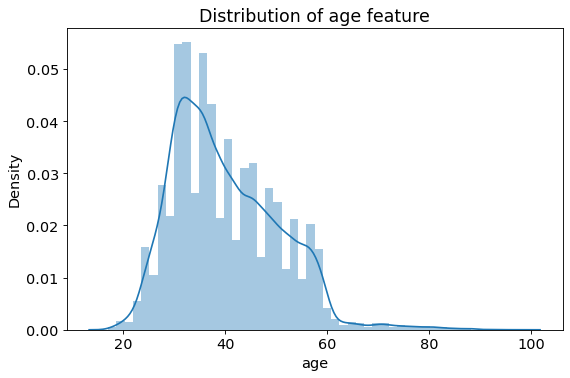

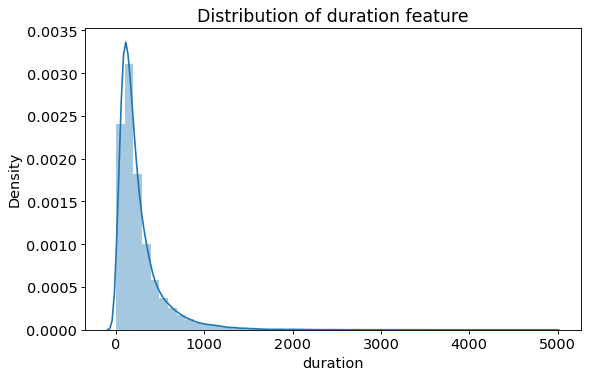

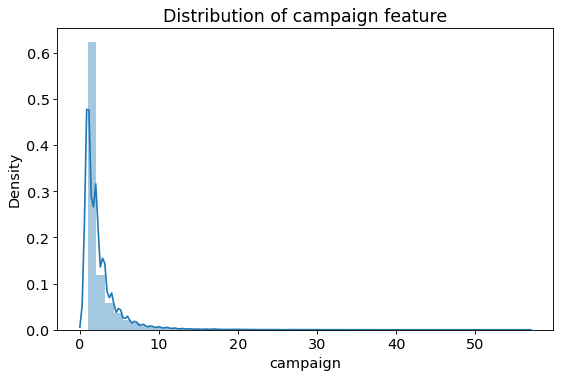

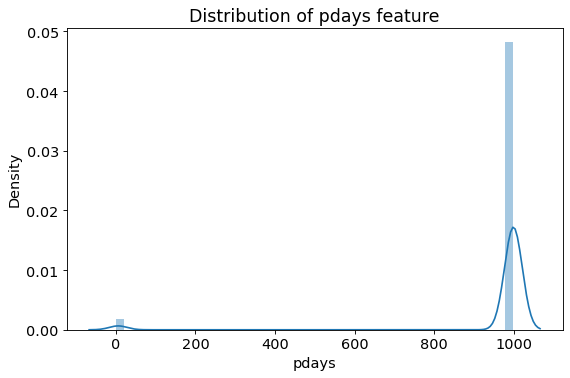

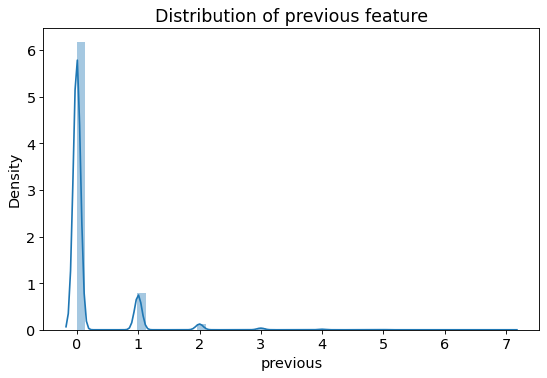

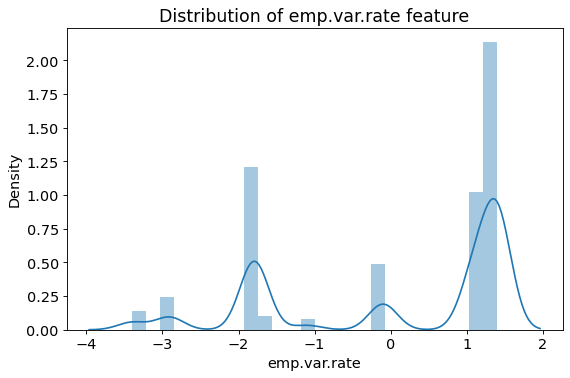

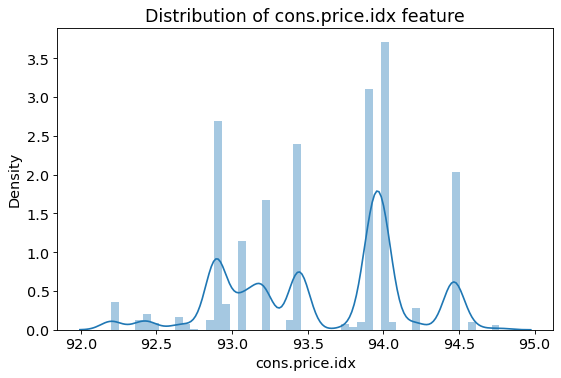

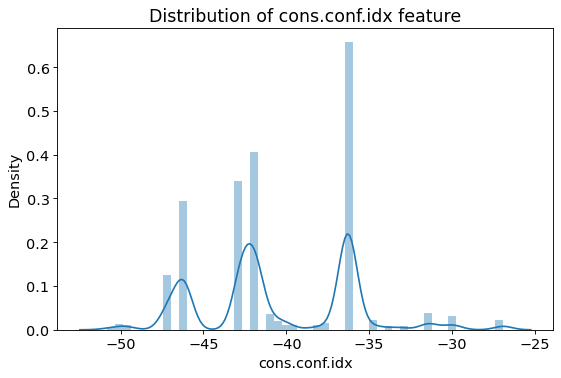

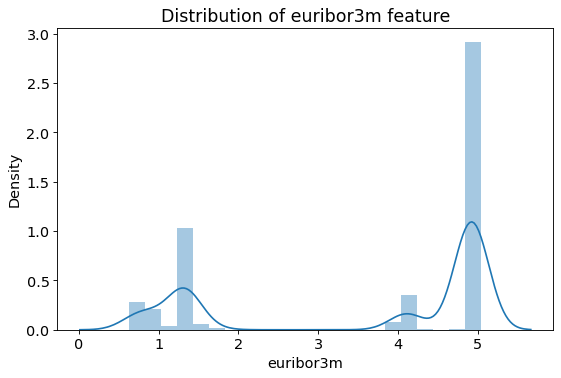

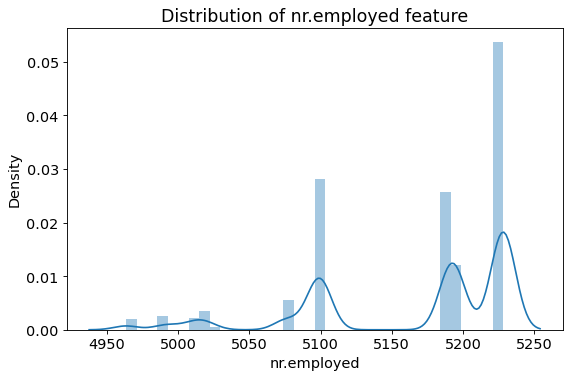

In [ ]:
# numeric data vusualization: distbution
for column in numeric_columns:
    plt.figure(figsize=(8, 5), dpi=80)
    sns.distplot(numeric_data[column])
    plt.xlabel(column)
    plt.title(f'Distribution of {column} feature')
    plt.show()

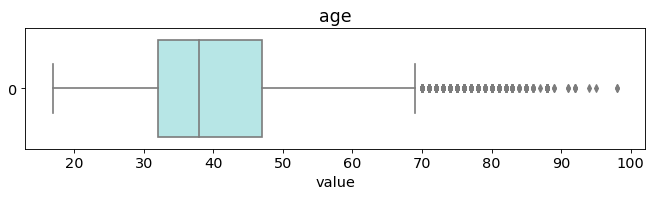

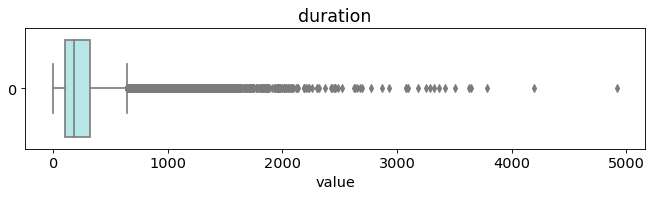

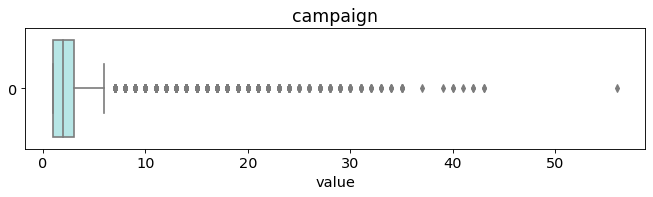

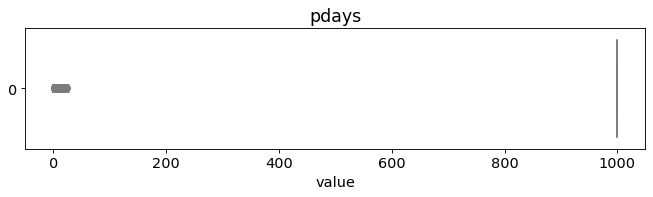

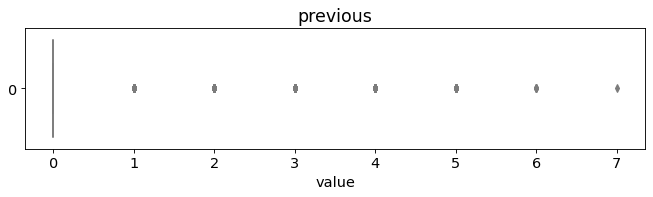

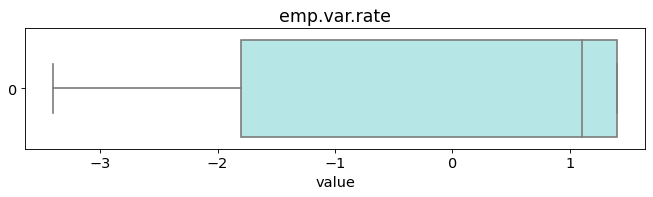

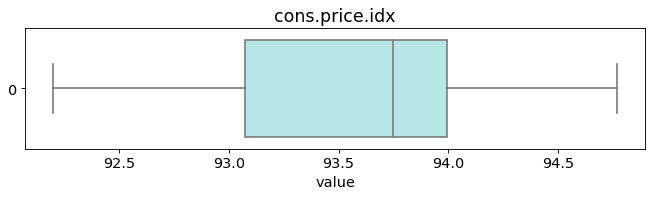

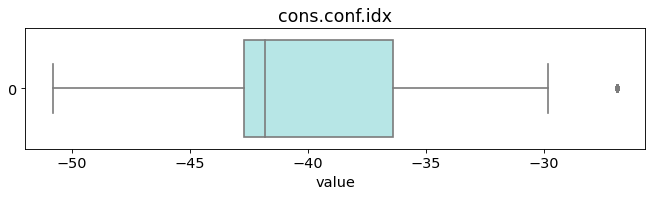

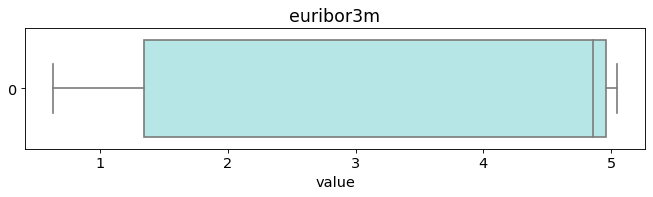

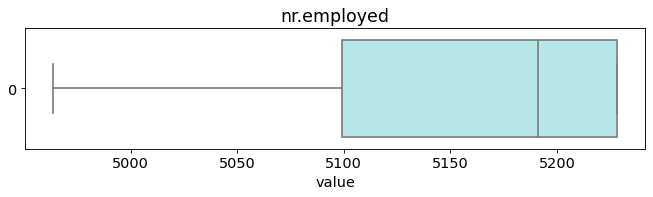

In [ ]:
# numeric data boxplot
for column in numeric_data:
    plt.figure(figsize=(10, 2), dpi=80)
    sns.boxplot(data=numeric_data[column], orient='h', color='paleturquoise')
    plt.title(column)
    plt.xlabel('value')
    
    plt.show()

#### Observations
1. Age-feature (continuous) seems to be unimodal normal distributed: Mean and median values are close and standart deviation looks good.
2. Duration (continuous) distribution obviously has outliers and deviation is large. Distribution is exponential like.
3. Campaign (discrete) max value is much bigger than 75% value and is a outlier. Std is ok. Distribution is exponential like.
4. Pdays (discrete): most of th eclients were not contacted before.
5. Previous (discrete): has one dominant value
6. emp.var.rate (discrete): polymodal distribution.
7. cons.price.idx (continuous): polymodal distribution.
8. cons.conf.idx (continuous): polymodal distribution.
9. euribor3m (continuous): bimodal distributoin
10. nr.employed (cntinuous): polymodal distribution.

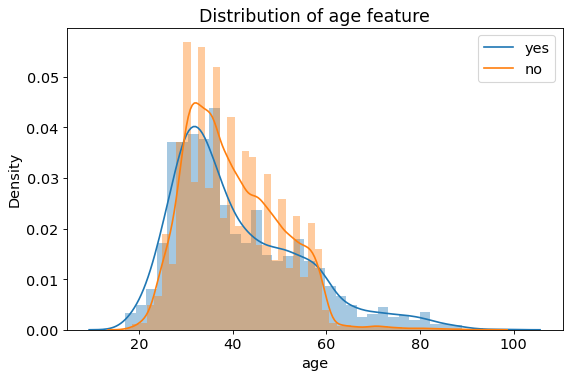

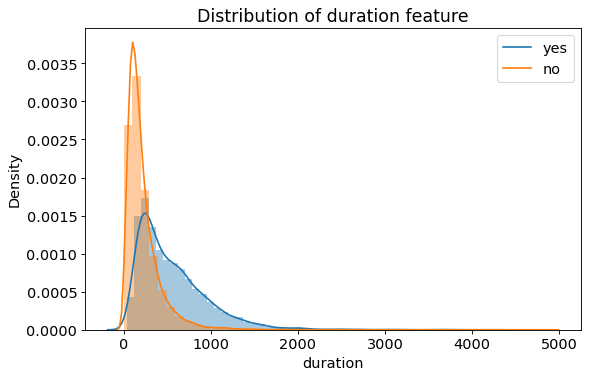

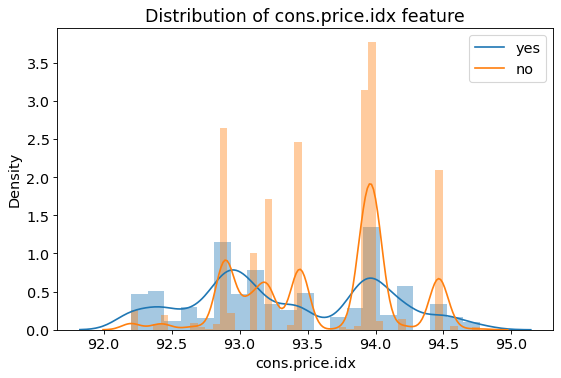

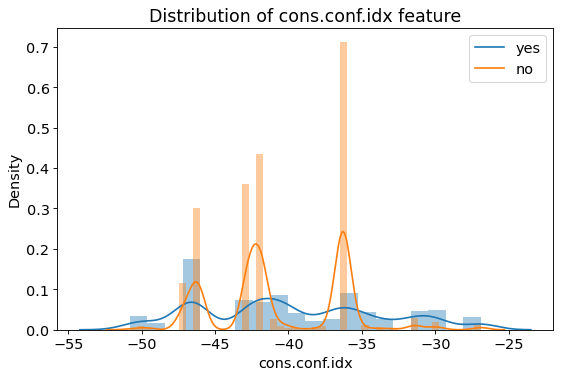

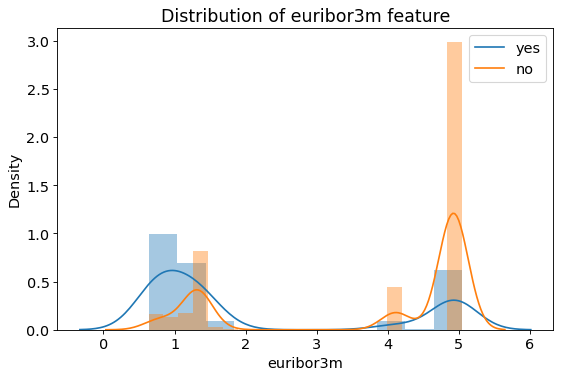

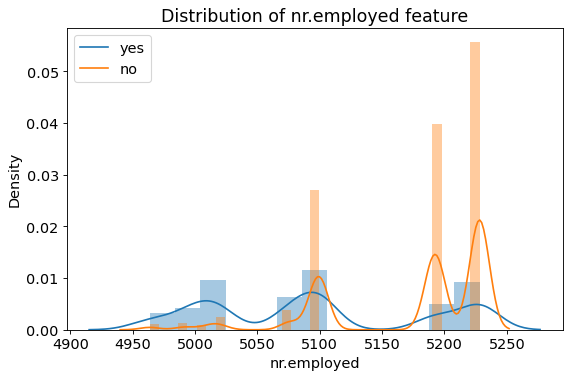

In [ ]:
# continuous data distribution depending on the target
continuous_features = ['age', 'duration', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

for column in continuous_features:
    plt.figure(figsize=(8, 5), dpi=80)

    target_yes = numeric_data[data['y'] == 'yes'][column]
    target_no = numeric_data[data['y'] == 'no'][column]

    sns.distplot(target_yes)
    sns.distplot(target_no)
    plt.xlabel(column)
    plt.title(f'Distribution of {column} feature')
    plt.legend(['yes', 'no'])

    plt.show()

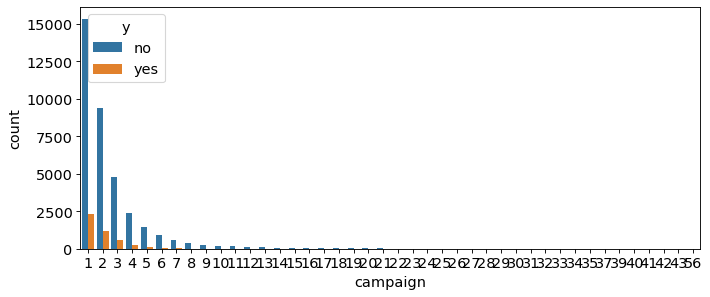

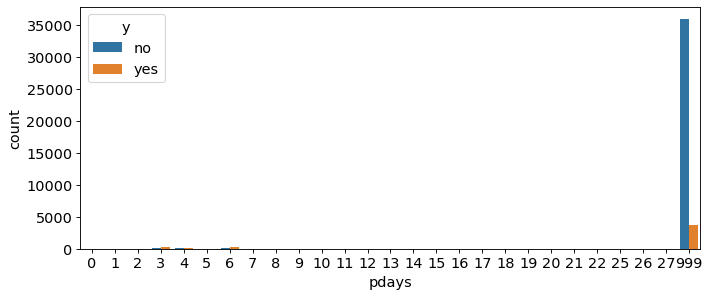

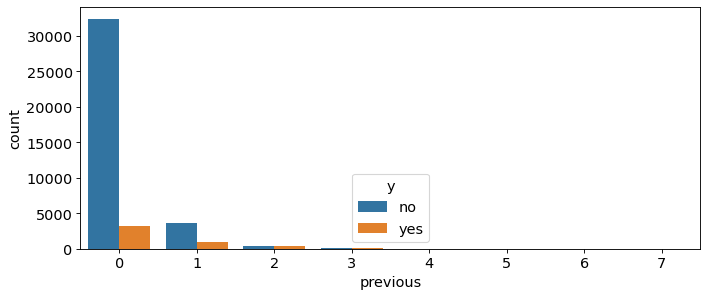

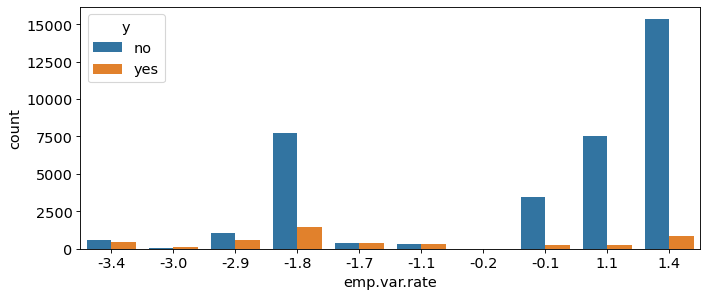

In [ ]:
# countplot for discrete data depending on the target
discrete_features = ['campaign', 'pdays', 'previous', 'emp.var.rate']

for column in discrete_features:
  plt.figure(figsize=(10, 4), dpi=80)
  sns.countplot(x=column, data=data, hue='y')
  plt.show()

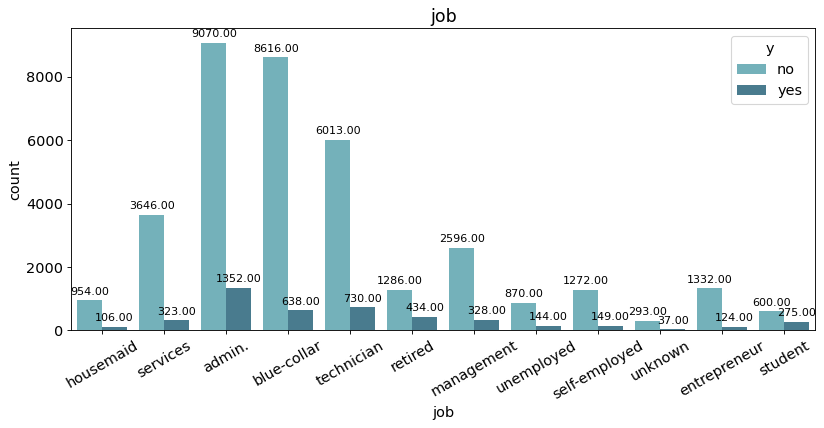

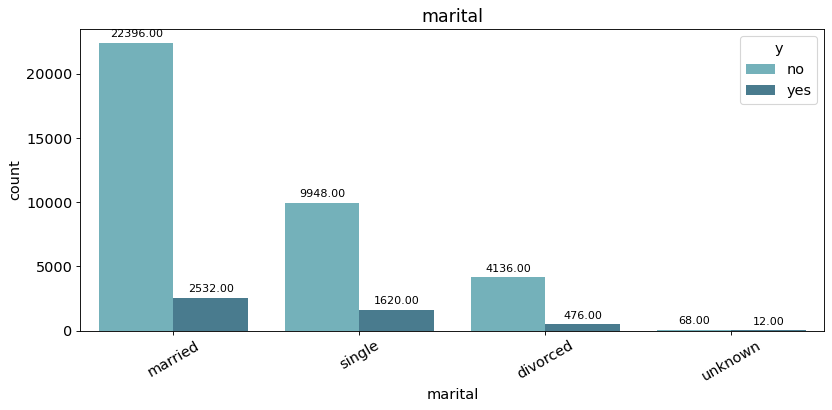

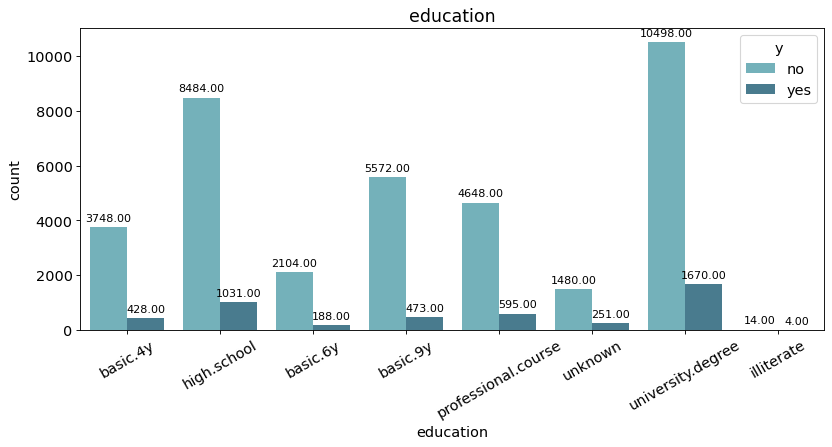

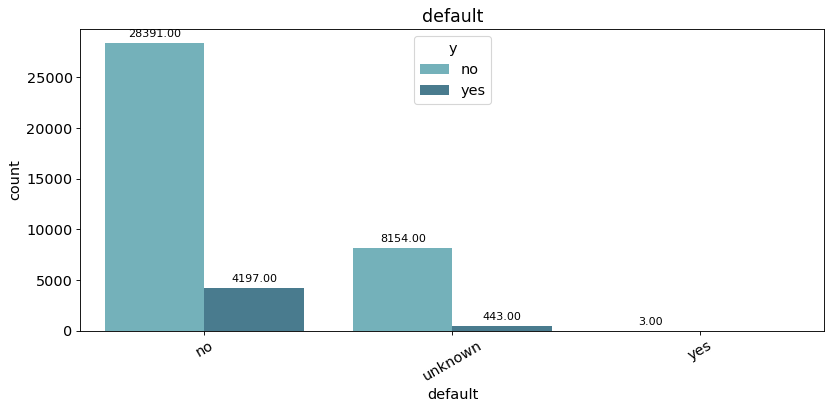

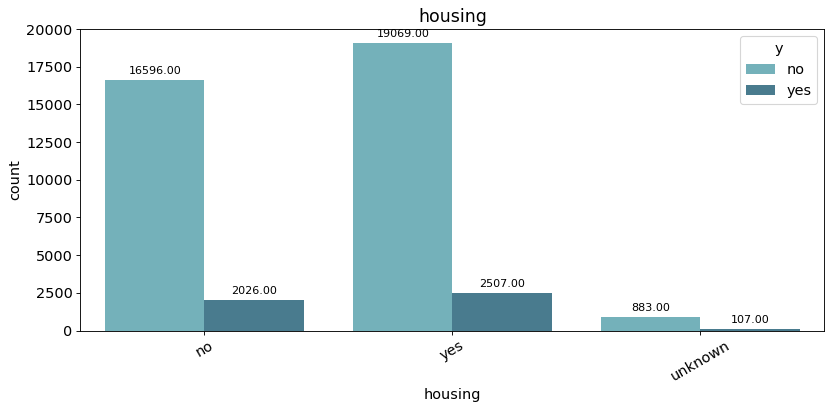

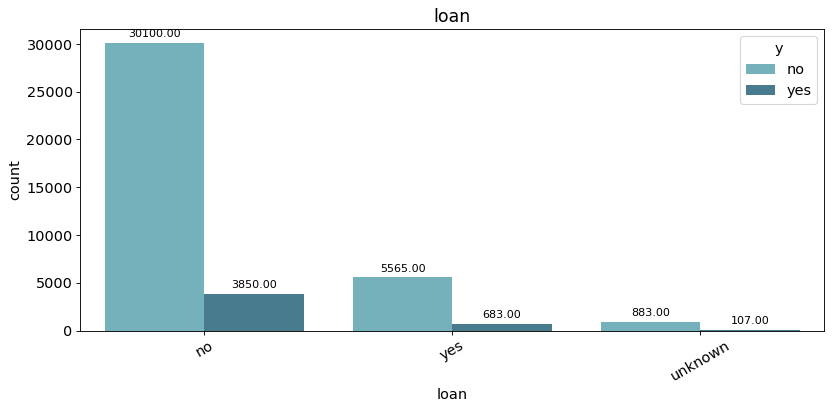

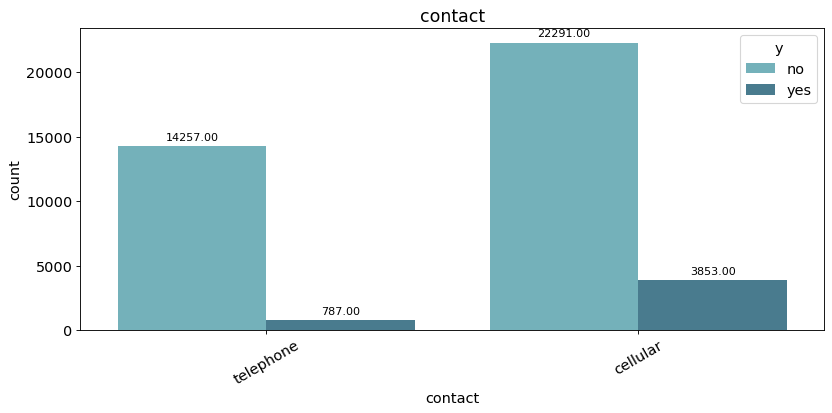

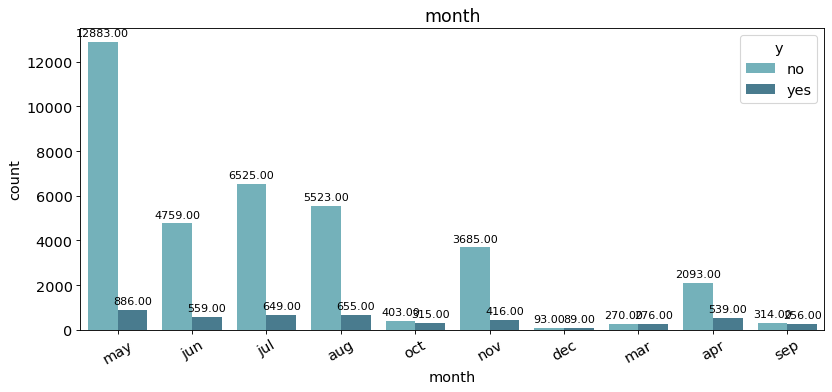

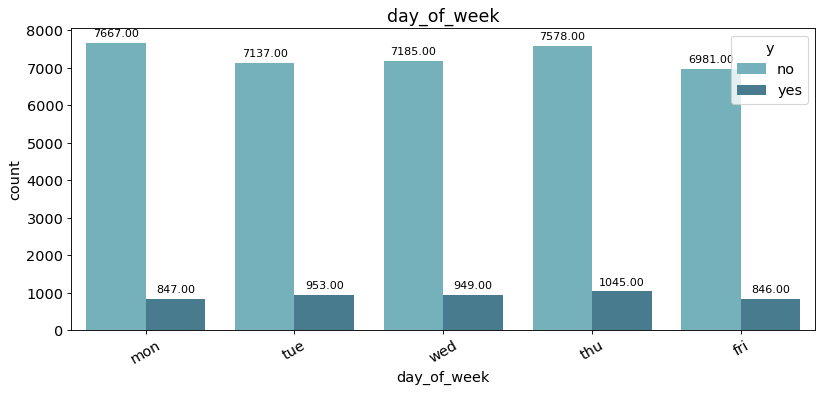

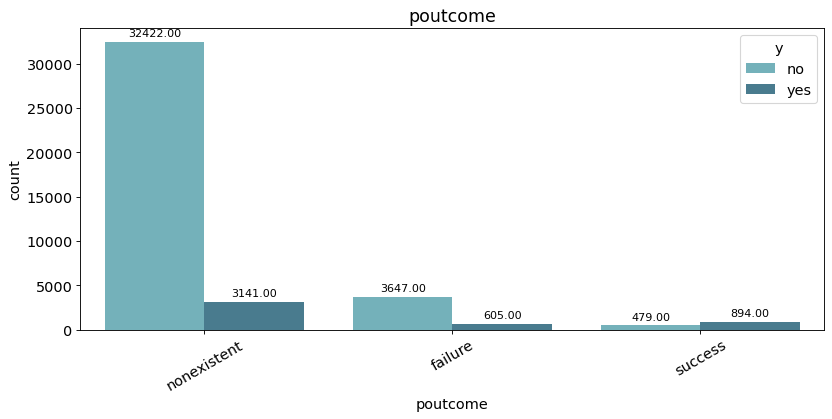

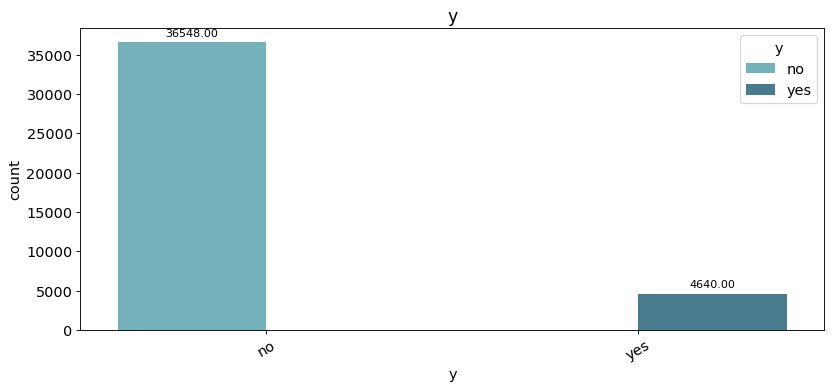

In [ ]:
# data visualization: categorical (nominal, order and binominal)
for column in categorical_data:
    plt.figure(figsize=(12,5), dpi=80)

    ax = sns.countplot(x=data[column].fillna('unknown'), palette='GnBu_d', hue=data['y'])
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
    plt.title(column)
    plt.xticks(rotation=30)
    plt.show()

#### Step 2. Multivariate analysis 

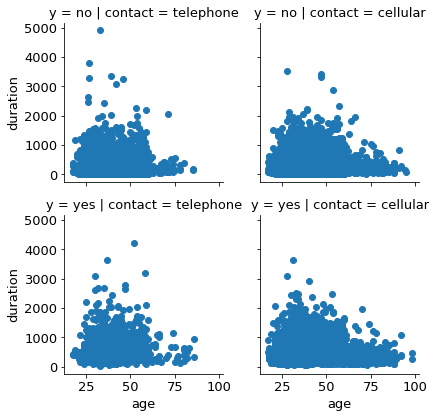

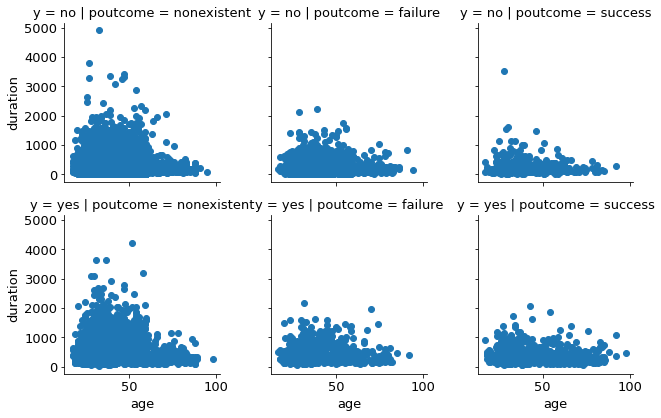

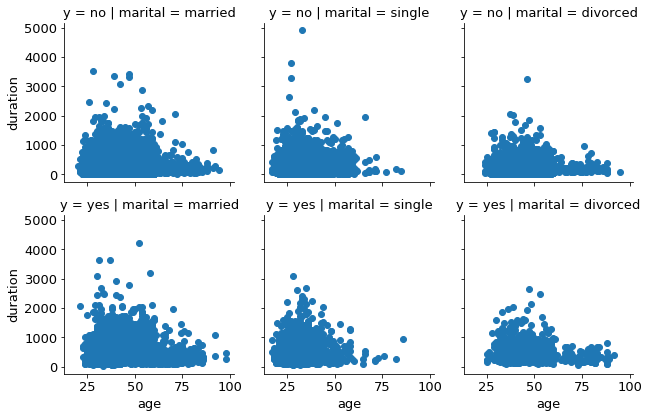

In [ ]:
to_compare = ['contact', 'poutcome', 'marital']

for o in to_compare:
  graph = sns.FacetGrid(data, col=o, row='y')
  graph.map(plt.scatter, "age", "duration").add_legend()

  plt.show()

### No significant differences were observed in terms of target value.
People tend to have longer consersations talking by cellular phone.

Clients eding telephone are younger in average compared to cellular phone users.

Successul outcome tend to have shorter phonecall compared to non-existent outcome (dramaticaly) and to failure outcome.

Among single clients, the age-distribution has narrower range.


In [ ]:
# considering features in pairs, looking for pairwise relations
numeric_data['target'] = target.map({'yes': 1, 'no': 0})
sns.pairplot(numeric_data.drop(['pdays', 'previous'], axis=1))
plt.show()

### Observations
1. The elder person is, the shorter the duration is.
2. People over 60 have less number of contacts performed during this campaign
4. People over 60 don't have number of employees more than 5100.
5. The more there were number of contacts performed this campaign or before, the shorter duration is.
6. The more there were number of contacts performed before this campaign and for this client, the less there are contacts during this campaign.
7. The more number of employees is, the more there are contancts during this campaign.
8. The more number of employees is, the less there were contancts before this campaign.

In [ ]:
# correlation
data_corr = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data_corr, annot=True)
plt.show()

#### Many features are correlated with each other (multicollinearity is observed)
To fix it we can:
1. delete some features which are correlated to another
2. instead of some correlated features, introduce a new variable which is a linear combination of them.

New features:
* I consider to create new feature based on  euribor3m feature as there is a strong border between two groups: euribor3m > 3 and euribor3m < 3. 
* There is also a pattern to split all clients into two groups by age: age < 60 and age > 60, because there is a significant difference between them on the pair plot.

In [ ]:
data['euribor3m>=3'] = np.array(['yes' if x >= 3 else 'no' for x in numeric_data['euribor3m']])

In [ ]:
data['is_senior'] = np.array(['yes' if x >= 60 else 'no' for x in numeric_data['age']])

## Part 2: DP

In [ ]:
# observe missing values
data.isnull().sum()

In [ ]:
# fill age with 0 to fill it later with KNNImputer
data['age'] = data['age'].fillna(value=-1)

In [ ]:
# delete rows with Nans in loan and housing as there are only 990 of them together
data.dropna(axis=0, inplace=True)

In [ ]:
binary_values = {'no':0, 'yes':1}

In [ ]:
def map_columns(df, values):
    '''
    map categorical values with given values
    '''
    for col in df.columns:
        df[col] = df[col].map(values)
    return df

In [ ]:
# transformers and pipelines for different features

binary_transform = FunctionTransformer(lambda x: map_columns(x, binary_values))

# for "education" feature I apply an ordinal encoder because a certain order between its values is observed:
# the education system is constacted in such way that the later one is based on the previous -->
# the higher is education level, the better it is valued. 
edu_pipe = Pipeline([('transform', OrdinalEncoder(categories=[['nan', 'illiterate','basic.4y', 
                                                               'basic.6y','basic.9y','high.school',
                                                               'professional.course','university.degree']])),
                     ('imputer', KNNImputer(n_neighbors=5, missing_values=0)),
                     ('scaler', StandardScaler())
                    ])

# for "outcome" feature I also applied ordinal encoding considering its values as "degree of success" that can be comparable.
outcome_pipe = Pipeline([('transform', OrdinalEncoder(categories=[['failure', 'nonexistent', 'success']])),
          ('scaler', StandardScaler())
        ])

# for categorical features
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent', fill_value='unknown')),
                     ('ohe', OneHotEncoder(sparse=False))) # It was choosen because the categorical features do not have many unique values
                    ])

# for numeric discrete and not macroeconomics features: no imputers are needed as no missing values are found
num_transform = StandardScaler()

# for other numeric features 
continuous_pipe = Pipeline([('function', FunctionTransformer(np.log1p)), # as we saw on EDA step, almost all features are skewed. log1p is used to make the distribution more centered.
                            ('imputer', KNNImputer(n_neighbors=5, missing_values=-1)),
                            ('scaler', RobustScaler()),   # RobustSCaler deals with outliers well. Also, my decision to use it is based in EDA observations
                            ])

In [ ]:
# split features and target value
target = data['y'].map(binary_values)
data.drop('y', axis=1, inplace=True)

In [ ]:
pipe = ColumnTransformer(transformers=[('edu', edu_pipe, ['education']),
                                       ('binary', binary_transform, ['housing', 'loan', 'euribor3m>=3', 'is_senior']),
                                       ('outcome', outcome_pipe, ['poutcome']),
                                       ('onehot_transform', cat_pipe, ['marital', 'contact', 'day_of_week', 'job', 'month']),
                                       ('numeric_transform', num_transform, ['campaign','emp.var.rate',
                                                                            'cons.price.idx','cons.conf.idx','euribor3m',
                                                                            'nr.employed']),
                                       ('continuous_pipe', continuous_pipe, ['age', 'duration'])])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42)

In [ ]:
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

## Part 3. DR

In [ ]:
# delete "pdays"-feature and "previous"-feature because of their uninformativeness (based on observations step 1).
data.drop(['pdays', 'previous'], axis=1, inplace=True)

In [ ]:
modified_data = pipe.fit_transform(data)

### PCA

In [ ]:
pca = PCA(n_components=0.99)
pca_data = pca.fit_transform(modified_data)

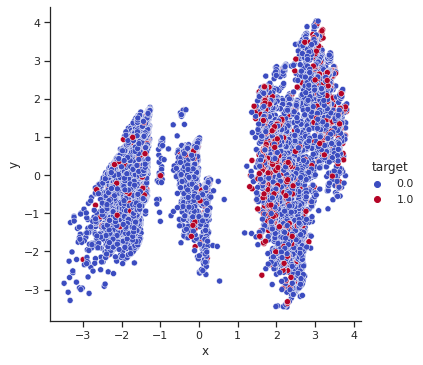

In [ ]:
plot_df = pd.DataFrame.from_records(data=pca_data[:,:2],columns=["x","y"])
plot_df["target"] = target

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')

In [ ]:
# calculate explained variance for PCA
pca.explained_variance_ratio_.sum()

0.9917446551230008

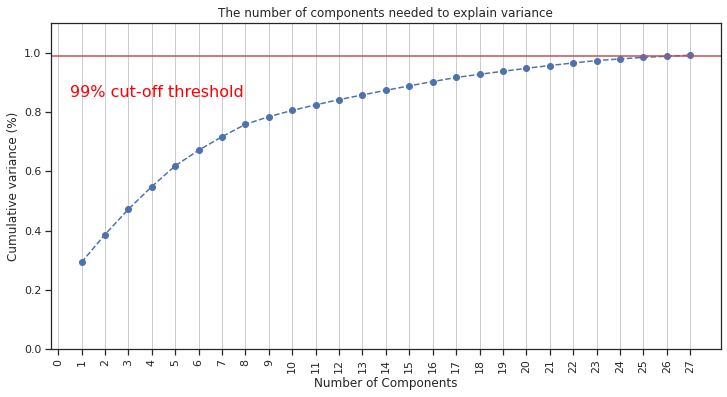

In [ ]:
# choose the best number of componentsfor PCA
number_of_ticks = len(pca.explained_variance_ratio_) + 1

fig, ax = plt.subplots(figsize=(12, 6))
x_ticks = np.arange(1, number_of_ticks, step=1)
y_values = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(x_ticks, y_values, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, number_of_ticks, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.xticks(rotation=90)
plt.show()

In this case, we can reach 99% with 27 principal components.

### SVD

In [ ]:
svd = TruncatedSVD(n_components=2, algorithm='arpack')
svd_data = svd.fit_transform(modified_data)

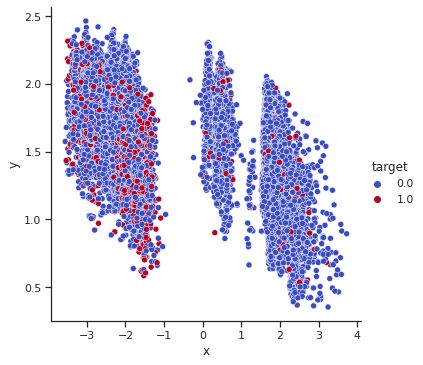

In [ ]:
plot_df = pd.DataFrame.from_records(data=svd_data[:,:2],columns=["x","y"])
plot_df["target"] = target

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')

In [ ]:
# calculate explained variance for PCA
svd.explained_variance_ratio_.sum()

0.30051749832960034

### UMAP

In [ ]:
embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.15).fit_transform(modified_data)

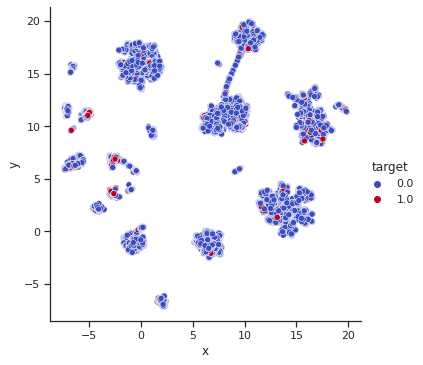

In [ ]:
plot_df = pd.DataFrame.from_records(data=embedding, columns=["x","y"])
plot_df["target"] = target

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')

### TSNE

In [ ]:
tsne = TSNE()
tsne_data = tsne.fit_transform(modified_data)

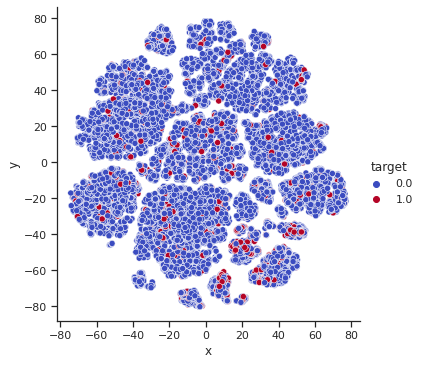

In [ ]:
plot_df = pd.DataFrame.from_records(data=tsne_data,columns=["x","y"])
plot_df["target"] = target

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='coolwarm')

## Conclusion


Different data types are presented in the given dataset:
1. Categorical types are devided into binary and non-binary.The target value belongs to binary type.
2. Numeric types are presented also in two groups: continuous and discrete.
  Some of continuous features are represented by a small groups of unique variables as they are changed rarely (once a quartal).

Overall about data:
1. Multicolinearity was observed.
2. Distribution of some features is dependent on target value.
3. Lots of features have skewed distribution
4. No mistakes and misspelings were observed
5. Taget value is binary and "no" value is dominant over "yes" value

Problems & Solutions:
1. Distribution: some of numeric features have skewed distribution --> np.log1p was applied.

2. Missing values: different approaches were considered to features:
  *  extra value "unknown" was created for categorical features or rows with NANs were deleted if there were not so many of them.
  *  KNNImputer was applied for most of the features
3. Outliers: their influence was minimized using Robust Scaling.
4. Categorical features: 
  * if it is binary, it was transformed to [1, 0] values
  * if they have ordinal nature, OrdinalEncoder was applied (education and outcome)
  * all others were one-hot-encoded.
5. Multicolinearity --> potential solutions were given in the section.
